In [1]:
import cv2, os, sys
import numpy as np

In [3]:
path  = "test_image_11.png"

In [4]:
image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

In [5]:
image

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [11]:
size = 10
erosion = 2

In [12]:
    row    = image.shape[0];
    col    = image.shape[1];

    pixels = 2*size + 1;                                     ## Double and plus 1 to have an odd-sized kernel
    kernel = np.ones((pixels,pixels),np.uint8)               ## How many pixel of extension do I get

    if erosion is not False:
        erosion = int(erosion)
        erosion_kernel = np.ones((3,3), np.uint8)                     ## Design an odd-sized erosion kernel
        image = cv2.erode(image, erosion_kernel, iterations=erosion)  ## How many erosion do you expect
        image = np.where(image > 0, 255, image)                       ## Any gray-clored pixel becomes white (smoothing)
        # Error-handler to prevent entire foreground annihilation
        if cv2.countNonZero(image) == 0:
            print("ERROR: foreground has been entirely eroded");
            sys.exit();

    dilation  = cv2.dilate(image, kernel, iterations = 1)

    dilation  = np.where(dilation == 255, 127, dilation) 	## WHITE to GRAY
    remake    = np.where(dilation != 127, 0, dilation)		## Smoothing
    remake    = np.where(image > 127, 200, dilation)		## mark the tumor inside GRAY

    remake    = np.where(remake < 127, 0, remake)		## Embelishment
    remake    = np.where(remake > 200, 0, remake)		## Embelishment
    remake    = np.where(remake == 200, 255, remake)		## GRAY to WHITE

    #############################################
    # Ensures only three pixel values available #
    # TODO: Optimization with Cython            #
    #############################################    
    for i in range(0,row):
        for j in range (0,col):
            if (remake[i,j] != 0 and remake[i,j] != 255):
                remake[i,j] = 127;

In [13]:
remake

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [14]:
from PIL import Image

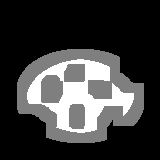

In [10]:
Image.fromarray(remake)

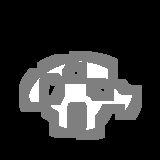

In [15]:
Image.fromarray(remake)

In [ ]:


def extractImage(path):
    # error handller if the intended path is not found
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE);
    return image

def checkImage(image):
    """
    Args:
        image: input image to be checked
    Returns:
        binary image
    Raises:
        RGB image, grayscale image, all-black, and all-white image
    """
    if len(image.shape) > 2:
        print("ERROR: non-binary image (RGB)");
        sys.exit();

    smallest = image.min(axis=0).min(axis=0); # lowest pixel value; should be 0 (black)
    largest  = image.max(axis=0).max(axis=0); # highest pixel value; should be 1 (white)

    if (smallest == 0 and largest == 0):
        print("ERROR: non-binary image (all black)");
        sys.exit();
    elif (smallest == 255 and largest == 255):
        print("ERROR: non-binary image (all white)");
        sys.exit();
    elif (smallest > 0 or largest < 255 ):
        print("ERROR: non-binary image (grayscale)");
        sys.exit();
    else:
        return True

class Toolbox:
    def __init__(self, image):
        self.image = image;

    @property
    def printImage(self):
        """
        Print image into a file for checking purpose
        unitTest = Toolbox(image);
        unitTest.printImage(image);
        """
        f = open("image_results.dat", "w+")
        for i in range(0, self.image.shape[0]):
            for j in range(0, self.image.shape[1]):
                f.write("%d " %self.image[i,j])
            f.write("\n")
        f.close()
        
    @property
    def displayImage(self):
        """
        Display the image on a window
        Press any key to exit
        """
        cv2.imshow('Displayed Image', self.image);
        cv2.waitKey(0);
        cv2.destroyAllWindows(); 

    def saveImage(self, title, extension):
        """
        Save as a specific image format (bmp, png, or jpeg)
        """
        cv2.imwrite("{}.{}".format(title,extension), self.image);        

    def morph_open(self, image, kernel):
        """
        Remove all white noises or speckles outside images
        Need to tune the kernel size
        Instruction:
        unit01 = Toolbox(image);
        kernel = np.ones( (9,9), np.uint8 );
        morph  = unit01.morph_open(input_image, kernel);
        """
        bin_open = cv2.morphologyEx(self.image, cv2.MORPH_OPEN, kernel)
        return bin_open

    def morph_close(self, image, kernel):
        """
        Remove all black noises or speckles inside images
        Need to tune the kernel size
        Instruction:
        unit01 = Toolbox(image);
        kernel = np.ones( (11,11)_, np.uint8 );
        morph  = unit01.morph_close(input_image, kernel);
        """        
        bin_close = cv2.morphologyEx(self.image, cv2.MORPH_CLOSE, kernel)
        return bin_close


def trimap(image, name, size, number, erosion=False):
    """
    This function creates a trimap based on simple dilation algorithm
    Inputs [4]: a binary image (black & white only), name of the image, dilation pixels
                the last argument is optional; i.e., how many iterations will the image get eroded
    Output    : a trimap
    """
    checkImage(image);
    
    row    = image.shape[0];
    col    = image.shape[1];

    pixels = 2*size + 1;                                     ## Double and plus 1 to have an odd-sized kernel
    kernel = np.ones((pixels,pixels),np.uint8)               ## How many pixel of extension do I get

    if erosion is not False:
        erosion = int(erosion)
        erosion_kernel = np.ones((3,3), np.uint8)                     ## Design an odd-sized erosion kernel
        image = cv2.erode(image, erosion_kernel, iterations=erosion)  ## How many erosion do you expect
        image = np.where(image > 0, 255, image)                       ## Any gray-clored pixel becomes white (smoothing)
        # Error-handler to prevent entire foreground annihilation
        if cv2.countNonZero(image) == 0:
            print("ERROR: foreground has been entirely eroded");
            sys.exit();

    dilation  = cv2.dilate(image, kernel, iterations = 1)

    dilation  = np.where(dilation == 255, 127, dilation) 	## WHITE to GRAY
    remake    = np.where(dilation != 127, 0, dilation)		## Smoothing
    remake    = np.where(image > 127, 200, dilation)		## mark the tumor inside GRAY

    remake    = np.where(remake < 127, 0, remake)		## Embelishment
    remake    = np.where(remake > 200, 0, remake)		## Embelishment
    remake    = np.where(remake == 200, 255, remake)		## GRAY to WHITE

    #############################################
    # Ensures only three pixel values available #
    # TODO: Optimization with Cython            #
    #############################################    
    for i in range(0,row):
        for j in range (0,col):
            if (remake[i,j] != 0 and remake[i,j] != 255):
                remake[i,j] = 127;

    path = "./images/results/"                                  ## Change the directory
    new_name = '{}px_'.format(size) + name + '_{}.png'.format(number);
    cv2.imwrite(os.path.join(path , new_name) , remake)


#############################################
###             TESTING SECTION           ###
#############################################
if __name__ == '__main__':

    path  = "./images/test_images/test_image_11.png";
    image = extractImage(path)

    size = 10;
    number = path[-5];
    title = "test_image"

    unit01  = Toolbox(image);
    kernel1 = np.ones( (11,11), np.uint8 );
    unit01.displayImage;
    
    opening = unit01.morph_close(image,kernel1);
    trimap(opening, title, size, number, erosion=False);
    unit02  = Toolbox(opening);
    unit02.displayImage;

    ########################################################
    ## Default instruction (no binary opening or closing  ##
    ## trimap(image, title, size, number, erosion=False); ##
    ########################################################